In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics
import keras.backend as K

from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, TimeDistributed
from keras.models import Model
from sklearn.metrics import mean_squared_error

from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from scapy.all import rdpcap, TCP, IP, Ether, wrpcap


from IPython import display

In [2]:
def packet_to_bits(packet):
    # Convert packet payload to a bit sequence (string of 0s and 1s)
    return ''.join(format(byte, '08b') for byte in bytes(packet))

# Load the pcap file
packets = rdpcap("real_opcua_packets.pcapng")

# List to hold bit sequences of OPC UA payloads
opcua_bit_sequences = []

for packet in packets:
    if TCP in packet and packet[TCP].dport == 4840 or packet[TCP].sport == 4840:  # Default OPC UA port
        payload = packet[TCP].payload
        if payload:
            bit_sequence = packet_to_bits(payload)
            opcua_bit_sequences.append(bit_sequence)

# opcua_bit_sequences now contains the bit sequences of OPC UA payloads
# You can print them or perform further analysis
print(opcua_bit_sequences[0])

0100100001000101010011000100011001001010000000000000000000000000000000000000000000000000000000001111111111111111111111110111111111111111111111111111111101111111000000000000000000000000000000000000000000000000000000000000000000101010000000000000000000000000011011110111000001100011001011100111010001100011011100000011101000101111001011110011000100110010001101110010111000110000001011100011000000101110001100010011101000110100001110000011010000110000001011110110011001110010011001010110010101101111011100000110001101110101011000010010111101110011011001010111001001110110011001010111001000101111


In [3]:
def create_new_pcap(synthetic_messages, synthetic_pcap):
    packets = []
    for message in synthetic_messages:
        packet = Ether()/IP()/TCP(dport=4840)/message
        packets.append(packet)
    wrpcap(synthetic_pcap, packets)

In [4]:
#uncomment two lines to revert changes
#real_messages = extract_messages('real.pcap') 
#bits_message = messages_to_bits(real_messages)

bits_message = opcua_bit_sequences
#Get the lengths of each payload message
message_lengths = [len(message) for message in bits_message]
# Use Counter to count the frequency of each length
frequency = Counter(message_lengths)
# Print the frequency of each number
for number, count in frequency.items():
    print(f'Number {number} appears {count} times.')


Number 592 appears 1 times.
Number 224 appears 1 times.
Number 1056 appears 1 times.
Number 1080 appears 1 times.
Number 2296 appears 1 times.
Number 4624 appears 1 times.
Number 1248 appears 1 times.
Number 768 appears 1 times.
Number 792 appears 2551 times.
Number 656 appears 2550 times.
Number 824 appears 2550 times.
Number 512 appears 2550 times.


In [52]:
#Truncate all messages to length of the mode in the frequency
#uncomment below line to revert
#truncated_bits_message = pad_sequences(bits_message, maxlen=statistics.mode(message_lengths), truncating='post')

truncated_bits_message = [message for message in bits_message if len(message) == 512]
#Get the lengths of each payload message
message_lengths = [len(message) for message in truncated_bits_message]
# Use Counter to count the frequency of each length
frequency = Counter(message_lengths)
# Print the frequency of each number
for number, count in frequency.items():
    print(f'Number {number} appears {count} times.')

# Convert each bit string to a list of integers
bit_lists = [[int(bit) for bit in string] for string in truncated_bits_message]

# Create a 2D NumPy array from the list of lists of integers
truncated_bits_message = np.array(bit_lists)

Number 512 appears 2550 times.


In [53]:
truncated_bits_message.shape

(2550, 512)

In [54]:
epochs = 100
input_dimension = truncated_bits_message.shape[1]
timesteps = 5
batch_size = 64
latent_dim = 16
num_sequences = len(truncated_bits_message)

# Pad the data to ensure the last sequences can continue from the beginning
padded_data = np.concatenate([truncated_bits_message[-timesteps+1:, :], truncated_bits_message, truncated_bits_message[:timesteps-1, :]])
# Initialize X with zeros
X_train = np.zeros((num_sequences, timesteps, truncated_bits_message.shape[1]))
# Populate X with sequences
for i in range(num_sequences):
    X_train[i, :, :] = padded_data[i:i+timesteps, :]

X_train.shape

(2550, 5, 512)

In [55]:
# Encoder
inputs = Input(shape=(timesteps, input_dimension))
x = LSTM(256, return_sequences=True)(inputs)  # Example LSTM layer, adjust the number of units as needed
#x = LSTM(128, return_sequences=True)(x)
#x = LSTM(64, return_sequences=True)(x)
x = LSTM(32)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
#encoder.summary()


80/80 [==============================] - 1s 5ms/step


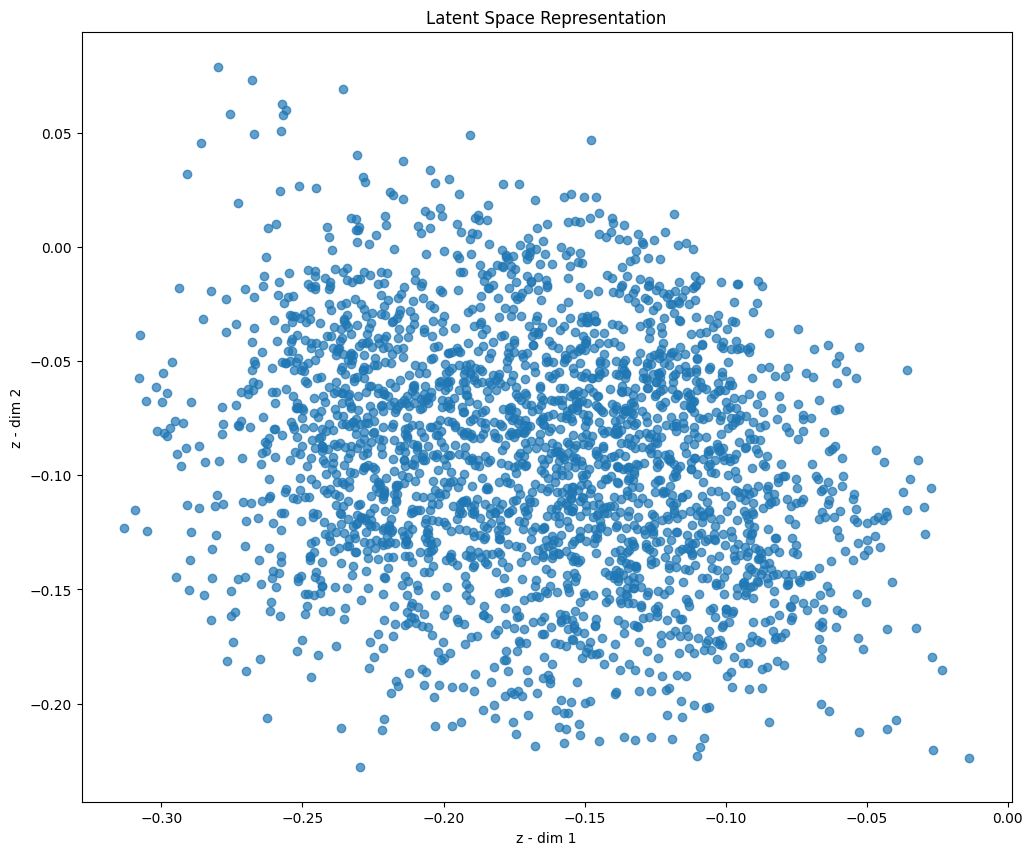

In [56]:

# Assuming 'encoder' is your VAE's encoder model and 'X_test' is your test dataset
z1_mean, _, _ = encoder.predict(X_train)

plt.figure(figsize=(12, 10))
plt.scatter(z1_mean[:, 0], z1_mean[:, 1], alpha=0.7)
plt.xlabel('z - dim 1')
plt.ylabel('z - dim 2')
plt.title('Latent Space Representation')
plt.show()


In [57]:
# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = RepeatVector(timesteps)(latent_inputs)
x = LSTM(32, return_sequences=True)(x)  # Match the LSTM units with the encoder
#x = LSTM(64, return_sequences=True)(x)
#x = LSTM(128, return_sequences=True)(x)
x = LSTM(256, return_sequences=True)(x)
outputs = TimeDistributed(Dense(input_dimension, activation='sigmoid'))(x)

# Decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
#decoder.summary()

In [58]:
# VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_lstm')

# Add VAE loss
reconstruction_loss = tf.keras.losses.mean_squared_error(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= timesteps * input_dimension
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [59]:
from keras.callbacks import EarlyStopping

# Assuming X_train is your training data and already normalized
# X_train shape: (num_samples, timesteps, features)


# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min')

history = vae.fit(
    X_train,  X_train, # VAEs are trained to reconstruct their input
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,  # Adjust the validation split as needed
    callbacks=[early_stopping]
)

Epoch 1/100
32/32 [==============================] - 11s 103ms/step - loss: 418.6148 - val_loss: 171.3893
Epoch 2/100
32/32 [==============================] - 1s 33ms/step - loss: 118.9581 - val_loss: 117.0403
Epoch 3/100
32/32 [==============================] - 1s 34ms/step - loss: 93.8090 - val_loss: 106.7310
Epoch 4/100
32/32 [==============================] - 1s 34ms/step - loss: 88.4348 - val_loss: 106.2275
Epoch 5/100
32/32 [==============================] - 1s 36ms/step - loss: 86.2409 - val_loss: 102.2335
Epoch 6/100
32/32 [==============================] - 1s 36ms/step - loss: 85.0230 - val_loss: 101.3132
Epoch 7/100
32/32 [==============================] - 1s 36ms/step - loss: 84.2323 - val_loss: 100.9190
Epoch 8/100
32/32 [==============================] - 1s 35ms/step - loss: 83.5943 - val_loss: 101.7106
Epoch 9/100
32/32 [==============================] - 1s 37ms/step - loss: 83.0092 - val_loss: 99.6843
Epoch 10/100
32/32 [==============================] - 1s 35ms/step - l

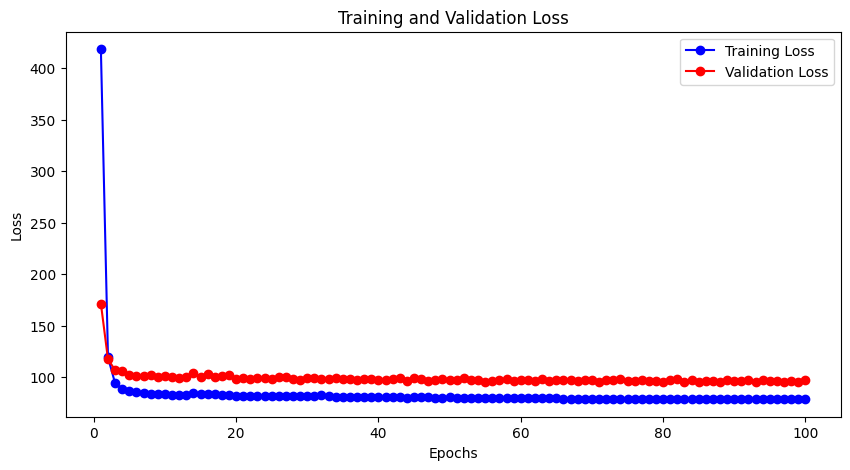

In [60]:
# Extract loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for the number of epochs
x_axis = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(x_axis, train_loss, 'bo-', label='Training Loss')
plt.plot(x_axis, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

80/80 [==============================] - 0s 4ms/step


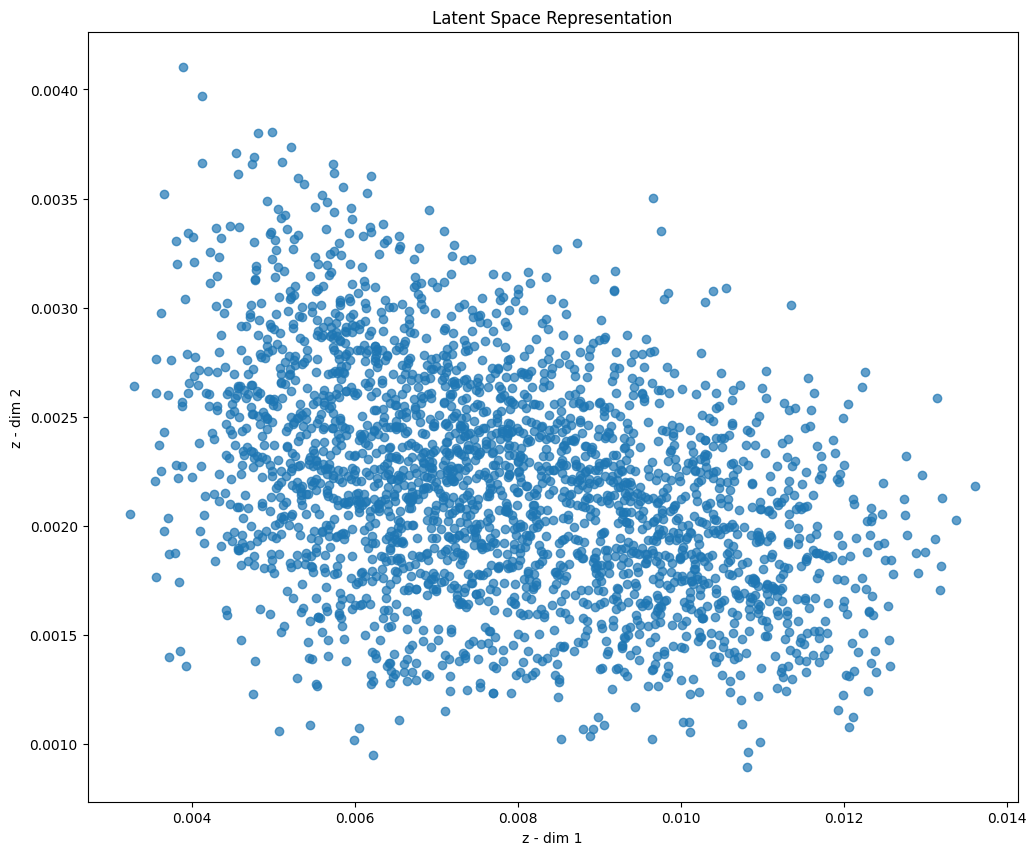

In [61]:

# Assuming 'encoder' is your VAE's encoder model and 'X_test' is your test dataset
z2_mean, _, _ = encoder.predict(X_train)

plt.figure(figsize=(12, 10))
plt.scatter(z2_mean[:, 0], z2_mean[:, 1], alpha=0.7)
plt.xlabel('z - dim 1')
plt.ylabel('z - dim 2')
plt.title('Latent Space Representation')
plt.show()


In [62]:
num_samples = 1000  # Number of time series sequences to generate
#latent_dim = 2    # This should match the latent space dimension of your VAE

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))


In [63]:
generated_data = decoder.predict(random_latent_vectors)

32/32 [==============================] - 1s 5ms/step


In [64]:
generated_data.shape

(1000, 5, 512)

In [65]:
def post_process(message):
    message = np.array(message)
    #Applying threshold to binarize the images
    message[message > 0.4] = 1
    message[message <= 0.4] = 0
    
    return message

generated_data = generated_data.reshape(-1, generated_data.shape[2])

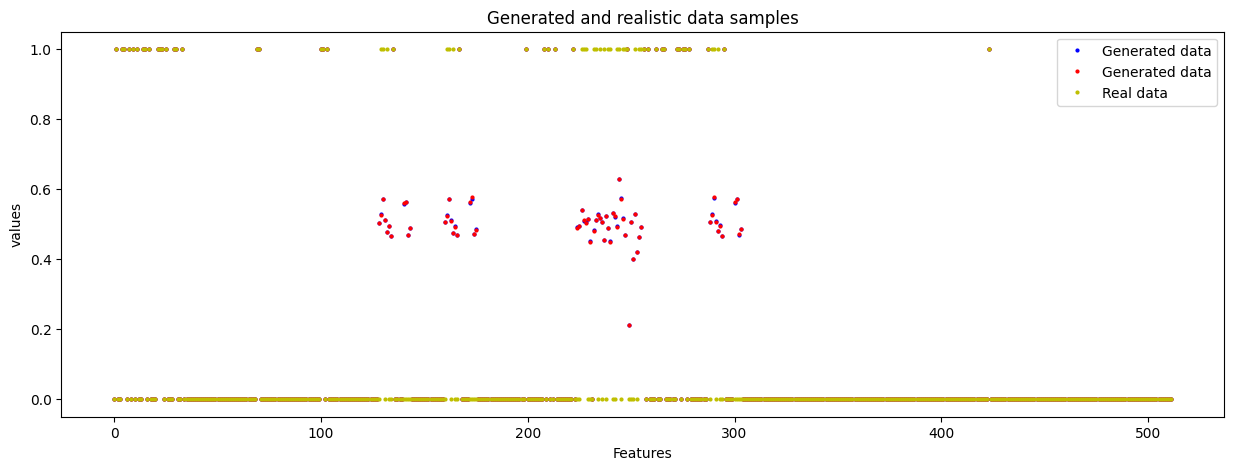

In [66]:
plt.figure(figsize=(15,5))
plt.plot(generated_data[7], 'bo', label='Generated data', markersize=2)
plt.plot(generated_data[99], 'ro', label='Generated data', markersize=2)
plt.plot(truncated_bits_message[50], 'yo', label='Real data', markersize=2)
plt.xlabel('Features')
plt.ylabel('values')
plt.title('Generated and realistic data samples')
plt.legend()
plt.show()

In [67]:

generated_data = post_process(generated_data)#Binarize the generated data with the post_process function

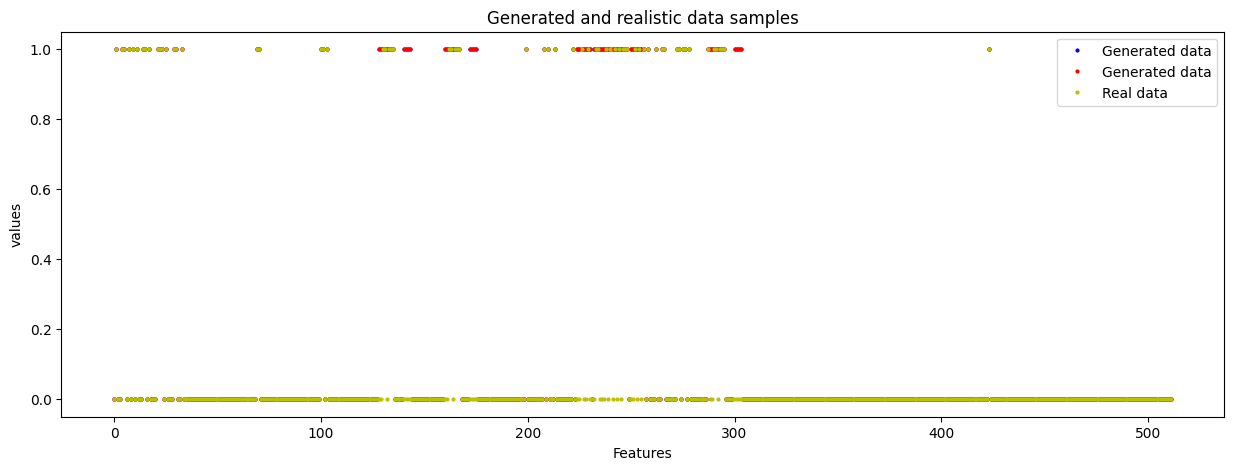

In [68]:
plt.figure(figsize=(15,5))
plt.plot(generated_data[20], 'bo', label='Generated data', markersize=2)
plt.plot(generated_data[49], 'ro', label='Generated data', markersize=2)
plt.plot(truncated_bits_message[25], 'yo', label='Real data', markersize=2)
plt.xlabel('Features')
plt.ylabel('values')
plt.title('Generated and realistic data samples')
plt.legend()
plt.show()

In [69]:
generated_data

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [70]:
# Find unique rows
_, unique_indices = np.unique(generated_data, axis=0, return_index=True)
unique_rows_count = len(unique_indices)

print(unique_rows_count)

2


In [71]:
def bits_to_messages(bit_sequences):
    messages = []
    for bit_sequence in bit_sequences:
        # Convert the list of bits back into a bytes object
        # First, convert the list of integers (bits) back into a string of bits
        bits_str = ''.join(str(int(bit)) for bit in bit_sequence)
        # Then, split the string into chunks of 8 bits
        byte_strings = [bits_str[i:i+8] for i in range(0, len(bits_str), 8)]
        # Convert each chunk of 8 bits into a byte
        message = bytes([int(byte_str, 2) for byte_str in byte_strings])
        messages.append(message)
    return messages


In [72]:
# Example usage:
messages = bits_to_messages(generated_data)
print(messages[9])  # Output should show the byte values corresponding to the bit sequences


b'MSGF@\x00\x00\x00\x06\x00\x00\x00\r\x00\x00\x00\xff\x0f\x00\x00\xff\x0f\x00\x00\x01\x00\xa4\x02\xfe\xff\xff\xbf\xa2`\xda\x01\xff\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'


In [73]:
unique_elements = set(messages)
print(len(unique_elements))

2


In [74]:
# Write the list of byte objects to a binary file
with open(r'D:\research\synthetic_opcua\SendingReceivingOPCUA\bytes_list_512.bin', 'wb') as file:
    for byte_obj in messages:
        file.write(byte_obj + b'\n')  # Adding a newline as a separator


In [28]:
vae.save_weights("SavedModel/model_weights.h5")

In [ ]:
vae.load_weights("SavedModel/model.h5")